In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3
%env TF_FORCE_GPU_ALLOW_GROWTH=true

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3
env: TF_FORCE_GPU_ALLOW_GROWTH=true


In [4]:
import os
import pymatgen
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
structures = pd.read_pickle("datasets/structures_defects.pickle.gzip")

In [6]:
# TODO(inner perfectionist) eval is unsecure
defects = pd.read_csv(
  "datasets/dichalcogenides_innopolis_202105/descriptors.csv", index_col="_id",
  converters={"cell": eval, "defects": eval})

In [7]:
from megnet.models import MEGNetModel
from megnet.data.graph import GaussianDistance
from megnet.data.crystal import CrystalGraph
from megnet.utils.preprocessing import StandardScaler
from megnet.callbacks import ModelCheckpointMAE
from pymatgen.core import Lattice, Structure, Molecule

import tensorflow as tf
import numpy as np

In [8]:
import wandb
from wandb.keras import WandbCallback

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# TODO(kazeevn) pass structure as the global state
train, test = train_test_split(structures, test_size=0.25, random_state=42)

In [ ]:
wandb.init(project='ai4material_design', entity='kazeev')

In [14]:
config = wandb.config
config.target = "energy_per_atom"

In [15]:
from typing import Union, List, Dict
from megnet.data.graph import StructureGraphFixedRadius
from pymatgen.analysis.local_env import NearNeighbors
from megnet.data.graph import Converter
class ZAwareStrucutreGraph(StructureGraphFixedRadius):
    def __init__(
        self,
        nn_strategy: Union[str, NearNeighbors] = "MinimumDistanceNNAll",
        atom_converter: Converter = None,
        bond_converter: Converter = None,
        cutoff: float = 5.0,
    ):
      raise NotImplemented("Doesn't work due to difficult estate planning")
      self.cutoff = cutoff
      super().__init__(
              nn_strategy=nn_strategy, atom_converter=atom_converter, bond_converter=bond_converter, cutoff=self.cutoff
      )
        
      @staticmethod
      def get_atom_features(structure):
        return [[i.species.Z, i.coords[2]] for i in structure.sites]

In [16]:
nfeat_edge = 10
gc = CrystalGraph(bond_converter=GaussianDistance(np.linspace(0, 15, nfeat_edge), 0.5),
                  cutoff=15)
model = MEGNetModel(nfeat_edge=nfeat_edge, nfeat_global=2, graph_converter=gc, npass=2)#.from_file('nikita_notebook_my_training')

In [17]:
scaler = StandardScaler.from_training_data(train.defect_representation,
                                           train[config.target], is_intensive=True)
model.target_scaler = scaler

In [ ]:
model.train(train.defect_representation, train[config.target],
            validation_structures=test.defect_representation,
            validation_targets=test[config.target],
#             callbacks=[WandbCallback()],
            epochs=2000, verbose=1, patience=1000)

In [18]:
model.load_weights('callback/val_mae_00703_0.011858.hdf5')

/home/aziz/.cache/pypoetry/virtualenvs/mos2-potential-learning-BpUrS1CK-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/aziz/.cache/pypoetry/virtualenvs/mos2-potential-learning-BpUrS1CK-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


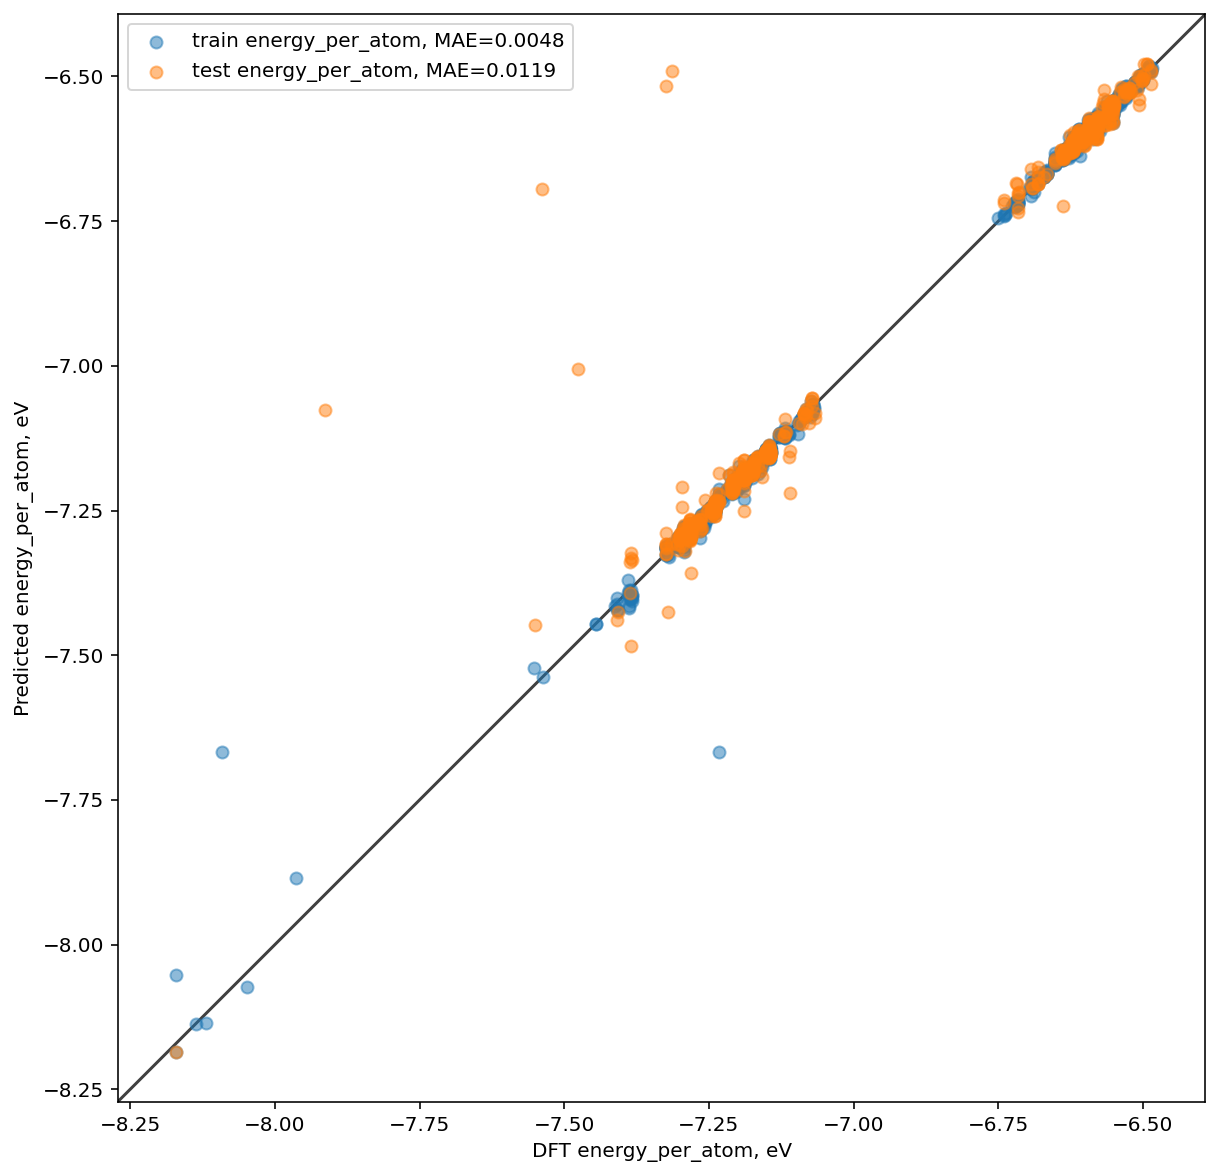

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))
for name, data in (("train", train), ("test", test)):
  prediction_column = f"predicted_{config.target}"
  data.loc[:, prediction_column] = model.predict_structures(data.defect_representation)
  ax.scatter(data.loc[:, config.target], data.loc[:, prediction_column],
             label=f"{name} {config.target}, MAE="
             f"{np.mean(np.abs(data.loc[:, config.target]-data.loc[:, prediction_column])):.4f}",
             alpha=0.5)
ax.set_xlabel(f"DFT {config.target}, eV")
ax.set_ylabel(f"Predicted {config.target}, eV")
ax.legend()

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
  ]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims);

In [20]:
# model.save_model('nikita_notebook_my_training')


In [21]:
from pymatgen.transformations.standard_transformations import RotationTransformation 


In [111]:
# def rand_rotation(defect):
#     defect['random_rotation'] = defect.defect_representation.copy()
#     coords = defect['random_rotation'].cart_coords
#     q, r = np.linalg.qr(np.random.rand(*coords.shape))
#     coords = q @ coords
#     print(type(defect))
#     return defect


def rand_rotation(defect):
    rotate = RotationTransformation([1, 0, 0], np.random.uniform(1, 360))
    defect['random_rotation'] = rotate.apply_transformation(defect.defect_representation)
    return defect

In [108]:
new_d = data.apply(rand_rotation, axis=1)


In [109]:
new_d['random_rot_energy_per_atom'] = model.predict_structures(new_d.random_rotation);

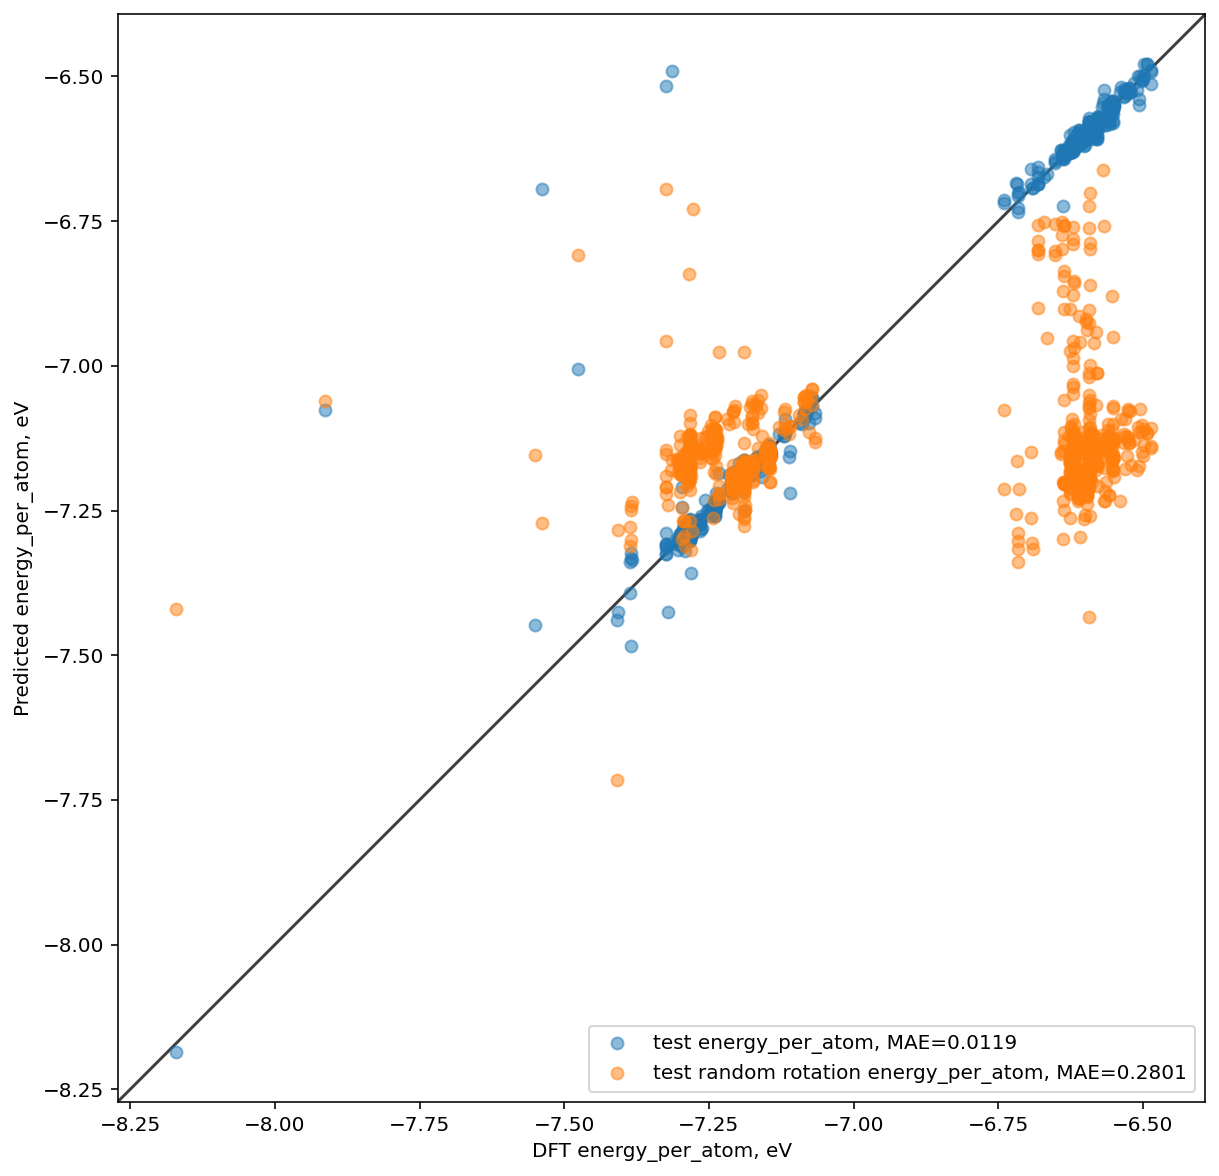

In [110]:
fig, ax = plt.subplots(figsize=(15, 10))

prediction_column = f"predicted_{config.target}"
new_d.loc[:, prediction_column] = model.predict_structures(data.defect_representation)
ax.scatter(data.loc[:, config.target], data.loc[:, prediction_column],
         label=f"test {config.target}, MAE="
         f"{np.mean(np.abs(data.loc[:, config.target]-data.loc[:, prediction_column])):.4f}",
         alpha=0.5)
ax.scatter(new_d.loc[:, config.target], new_d.loc[:,'random_rot_energy_per_atom'],
         label=f"test random rotation {config.target}, MAE="
         f"{np.mean(np.abs(new_d.loc[:, config.target]-new_d.loc[:, 'random_rot_energy_per_atom'])):.4f}",
         alpha=0.5)
ax.set_xlabel(f"DFT {config.target}, eV")
ax.set_ylabel(f"Predicted {config.target}, eV")
ax.legend()

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
  ]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims);